# Differential Expression with limma-voom pipeline

## Load Libraries

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(variancePartition)
                  library(BiocParallel)
                  library(data.table)
                  library(disk.frame)
                  library(tidyverse)
                  library(memoise)
                  library(limma)
                  library(edgeR)
                  library(glue)
                  library(sva)})

## Define functions

### Simple functions

In [2]:
set_parallel <- function(feature){
    parallel_param = list("genes"=32, "transcripts"=16, 
                          "exons"=10, "junctions"=12)
    param = SnowParam(parallel_param[[feature]], 
                      "SOCK", progressbar=FALSE)
    register(param)
}


load_counts <- function(region, feature){
    if(region == 'caudate'){
        counts_lt = list("genes"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                        "caudate_brainseq_phase3_hg38_rseGene_merged_n464.rda"), 
                         "transcripts"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                              "caudate_brainseq_phase3_hg38_rseTx_merged_n464.rda"),
                         "exons"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                        "caudate_brainseq_phase3_hg38_rseExon_merged_n464.rda"),
                         "junctions"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                            "caudate_brainseq_phase3_hg38_rseJxn_merged_n464.rda"))
        tx_file = "/ceph/projects/v4_phase3_paper/inputs/counts/_m/transcripts_counts/caudate_counts.txt"
    } else if(region == 'dlpfc'){
        counts_lt = list("genes"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                        "dlpfc_ribozero_brainseq_phase2_hg38_rseGene_merged_n453.rda"), 
                         "transcripts"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                              "dlpfc_ribozero_brainseq_phase2_hg38_rseTx_merged_n453.rda"),
                         "exons"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                        "dlpfc_ribozero_brainseq_phase2_hg38_rseExon_merged_n453.rda"),
                         "junctions"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                            "dlpfc_ribozero_brainseq_phase2_hg38_rseJxn_merged_n453.rda"))
        tx_file = "/ceph/projects/v4_phase3_paper/inputs/counts/_m/transcripts_counts/dlpfc_counts.txt"
    } else {
        counts_lt = list("genes"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                        "hippo_brainseq_phase2_hg38_rseGene_merged_n447.rda"), 
                         "transcripts"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                              "hippo_brainseq_phase2_hg38_rseTx_merged_n447.rda"),
                         "exons"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                        "hippo_brainseq_phase2_hg38_rseExon_merged_n447.rda"),
                         "junctions"=paste0("/ceph/projects/v4_phase3_paper/inputs/counts/_m/",
                                            "hippo_brainseq_phase2_hg38_rseJxn_merged_n447.rda"))
        tx_file = "/ceph/projects/v4_phase3_paper/inputs/counts/_m/transcripts_counts/hippo_counts.txt"
    }
    return(list("count_file"=counts_lt[[feature]], "tx_file"=tx_file))
}


get_model <- function(){
    covs = c('Dx', 'Age', 'rRNA_rate', 'totalAssignedGene', 'RIN', 
             'ERCCsumLogErr', 'overallMapRate', 'mitoRate', 'snpPC1', 
             'snpPC2', 'snpPC3', 'Sex', 'Region', 'BrNum')
    adjust_covs = covs[1:11]
    random_effect = covs[14]
    formula <- glue("~ Sex * Region + ", 
                    glue_collapse(adjust_covs, sep = " + ")) %>% 
        glue(" + (1|{random_effect})")
    return(formula)
}


get_null <- function(){
    covs = c('Dx', 'Age', 'rRNA_rate', 'totalAssignedGene', 'RIN', 
             'ERCCsumLogErr', 'overallMapRate', 'mitoRate', 'snpPC1', 
             'snpPC2', 'snpPC3', 'Sex', 'Region', 'BrNum')
    adjust_covs = covs[1:11]
    random_effect = covs[14]
    null_form <- glue("~ ", glue_collapse(adjust_covs[2:11], sep = " + ")) %>% 
      glue(" + (1|{random_effect}) + (1|Dx)")
    return(null_form)
}


save_volcanoPlot <- function(top, label, feature){
    pdf(file=paste0(feature, "/volcanoPlot_", label, ".pdf"), 8, 6)
    with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
    with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                              pch=20, col='red', cex=0.6))
    with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                              pch=20, col='orange', cex=0.6))
    with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
         points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
    dev.off()
}


save_MAplot <- function(top, label, feature){
    pdf(file=paste0(feature, "/MAplot_", label, ".pdf"), 8, 6)
    with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
    with(subset(top, adj.P.Val<0.05),
         points(AveExpr, logFC, col="red", pch=20, cex=0.5))
    dev.off()
}


extract_de <- function(contrast, label, fit, feature){
    top <- topTable(fit, coef=contrast, number=Inf, sort.by="P")
    top <- top[order(top$P.Value), ]
    top.fdr <- top %>% filter(adj.P.Val<=0.05)
    print(paste("Comparison for:", label))
    print(paste('There are:', dim(top.fdr)[1], 'DE features!'))
    fwrite(top, 
           file=paste0(feature, "/diffExpr_", label, "_full.txt"), 
           sep='\t', row.names=TRUE)
    fwrite(top.fdr, 
           file=paste0(feature, "/diffExpr_", label, "_FDR05.txt"), 
           sep='\t', row.names=TRUE)
    save_volcanoPlot(top, label, feature)
    save_MAplot(top, label, feature)
}


get_juncs <- function(region){
    lt = load_counts(region, "junctions")
    load(lt[['count_file']])
    rse_df = rse_jxn
    genes = rowData(rse_df) %>% as.data.frame
    return(rownames(genes))
}

### Cached functions

In [3]:
get_mds <- function(){
    mds_file = "/ceph/projects/v4_phase3_paper/inputs/genotypes/mds/_m/LIBD_Brain_TopMed.mds"
    mds = data.table::fread(mds_file) %>%
        rename_at(.vars = vars(starts_with("C")),
                  function(x){sub("C", "snpPC", x)}) %>%
        mutate_if(is.character, as.factor)
    return(mds)
}

memMDS <- memoise::memoise(get_mds)

get_overlapping_juncs <- function(){
    common_genes = intersect(intersect(get_juncs("caudate"), get_juncs("dlpfc")), get_juncs("hippocampus"))
    return(common_genes)                
}

memJuncs <- memoise(get_overlapping_juncs)

prep_data <- function(feature){
    datalist1 = list()
    datalist2 = list()
    for(region in c('dlpfc', 'caudate', 'hippocampus')){
        print(region)
        flush.console()
        lt = load_counts(region, feature)
        load(lt[['count_file']])
        tx_file = lt[['tx_file']]
        if (exists("rse_gene")){
            rse_df = rse_gene
        } else if (exists("rse_tx")){
            if(region == 'caudate' && exists("geneid")){
                counts <- fread(tx_file) %>% filter(gencodeTx %in% geneid) %>%
                    column_to_rownames("gencodeTx") %>% 
                    select(-c(txLength, gencodeID, Symbol, gene_type)) %>% 
                    select(colnames(rse_tx)) %>% as.matrix 
                rse_df <- SummarizedExperiment(assays=SimpleList(counts=counts),
                                               rowData=annot, colData=colData(rse_tx)) %>%
                    as("RangedSummarizedExperiment")
            } else {
                counts <- fread(tx_file) %>% column_to_rownames("transcript_id") %>%
                    select(colnames(rse_tx)) %>% as.matrix
                annot <- fread(tx_file) %>% column_to_rownames("transcript_id") %>%
                    select(-starts_with("R"))
                rse_df <- SummarizedExperiment(assays=SimpleList(counts=counts),
                                               rowData=annot, 
                                               colData=colData(rse_tx)) %>%
                    as("RangedSummarizedExperiment")
                geneid = rownames(rowData(rse_df))
            }
        } else if (exists("rse_exon")){
            rse_df = rse_exon
        } else {
            rse_df = rse_jxn
        }
        keepIndex = which((rse_df$Dx %in% c("Control", "Schizo")) & 
                          rse_df$Age > 17 & rse_df$Race %in% c("AA", "CAUC"))
        rse_df = rse_df[, keepIndex]
        rse_df$Sex <- factor(rse_df$Sex)
        rse_df <- jaffelab::merge_rse_metrics(rse_df)
        colData(rse_df)$RIN = sapply(colData(rse_df)$RIN,"[",1)
        colData(rse_df)$ERCCsumLogErr = sapply(colData(rse_df)$ERCCsumLogErr,"[",1)
        rownames(colData(rse_df)) <- sapply(strsplit(rownames(colData(rse_df)), "_"), "[", 1)
        pheno = colData(rse_df) %>% as.data.frame %>% 
            inner_join(memMDS(), by=c("BrNum"="FID")) %>% 
            distinct(RNum, .keep_all = TRUE) 
        if(feature == "junctions"){
            datalist1[[region]] <- assays(rse_df)$counts[, pheno$RNum] %>% as.data.frame %>% 
                rownames_to_column("V1") %>% filter(V1 %in% memJuncs()) %>% 
                column_to_rownames("V1") %>% t %>% as.data.frame
        }else{
            datalist1[[region]] <- assays(rse_df)$counts[, pheno$RNum] %>% t %>% 
                as.data.frame 
        }
        datalist2[[region]] <- pheno[, c('Sex', 'Dx', 'Age', 'rRNA_rate', 'totalAssignedGene', 
                                         'RIN','ERCCsumLogErr', 'overallMapRate', 'mitoRate', 
                                         'snpPC1', 'snpPC2', 'snpPC3', 'Region', 'BrNum', 'RNum')]
    }
    samples <- bind_rows(datalist2) %>% as.data.frame %>% 
        mutate_if(is.numeric, rescale)
    subjects = samples$BrNum
    if(feature == "junctions"){
        genes = rowData(rse_df) %>% as.data.frame %>% rownames_to_column("V1") %>%
            filter(V1 %in% memJuncs()) %>% column_to_rownames("V1") 
    } else {
        genes = rowData(rse_df) %>% as.data.frame
    }
    counts <- bind_rows(datalist1) %>% t %>% as.data.frame
    colnames(counts) <- samples$RNum
    if(samples %>% has_rownames){
        samples = samples %>% select(-RNum)
    } else {
        samples = samples %>% column_to_rownames("RNum")
    }
    # Generate DGE list
    x <- DGEList(counts=counts[, row.names(samples)], 
                 genes=genes, samples=samples)
    # Filter by expression
    design0 <- model.matrix(~Sex*Region, data=x$samples)
    keep.x <- filterByExpr(x, design=design0)
    x <- x[keep.x, , keep.lib.sizes=FALSE]
    print(paste('There are:', sum(keep.x), 'features left!', sep=' '))
    # Normalize library size
    x <- calcNormFactors(x, method="TMM")
    return(x)
}

memo_prepData <- memoise(prep_data)

plot_corrMatrix <- function(feature){
    x <- memo_prepData(feature)
    covs = c('Dx', 'Age', 'rRNA_rate', 'totalAssignedGene', 'RIN', 
             'ERCCsumLogErr', 'overallMapRate', 'mitoRate', 'snpPC1', 
             'snpPC2', 'snpPC3', 'Sex', 'Region', 'BrNum')
    form <- paste('~', glue_collapse(covs, sep=" + "))
    # Compute Canonical Correlation Analysis (CCA)
    # between all pairs of variables# returns absolute correlation value
    C = canCorPairs(form, x$samples)
    # Plot correlation matrix
    plotCorrMatrix( C )
}

memo_corrMatrix <- memoise(plot_corrMatrix)

get_voom <- function(feature){
    memo_corrMatrix(feature)
    x <- memo_prepData(feature)
    vobjDream = voomWithDreamWeights(x, get_model(), 
                                     x$samples, plot=TRUE)
    return(vobjDream)
}

memo_voom <- memoise(get_voom)

fit_dream <- function(feature){
    x <- memo_prepData(feature)
    vobj <- memo_voom(feature)
    # define and then cbind contrasts
    L1 = getContrast(vobj, get_model(), x$samples, 
                     c("RegionDLPFC", "RegionHIPPO"))
    L2 = getContrast(vobj, get_model(), x$samples, 
                     c("SexM:RegionDLPFC", "SexM:RegionHIPPO"))
    # combine contrasts
    L = cbind(L1, L2)     
    # Visualize contrasts
    plotContrasts(L) 
    fit = dream(vobj, get_model(), x$samples, L=L)
    return(fit)
}

memo_dream <- memoise(fit_dream)

cal_res <- function(feature){
    ### Calculate residuals
    vobj <- memo_voom(feature)
    residList <- fitVarPartModel(vobj, get_null(), vobj$targets, fxn=residuals)
    do.call(rbind, residList) %>% as.data.frame %>% 
        rownames_to_column %>% rename(Geneid=rowname) %>% 
        fwrite(file=paste0(feature, '/residualized_expression.tsv'), sep='\t')
}

memo_res <- memoise(cal_res)

## Main loop

[1] "Set parallel!"
[1] "Prepare data!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 26385 features left!"
[1] "Preform voom!"


Warning message in canCorPairs(form, x$samples):
“Regression model may be problematic.
High colinearity between variables:
  Dx and BrNum
  Age and BrNum
  snpPC1 and BrNum
  snpPC2 and BrNum
  snpPC3 and BrNum
  Sex and BrNum”
Memory usage to store result: >2 Gb

Dividing work into 100 chunks...


Total:488 s



[1] "Fit model!"


Dividing work into 100 chunks...


Total:772 s



[1] "Comparison for: sex"
[1] "There are: 704 DE features!"
[1] "Comparison for: CvD_sex"
[1] "There are: 668 DE features!"
[1] "Comparison for: CvH_sex"
[1] "There are: 23 DE features!"
[1] "Comparison for: DvH_sex"
[1] "There are: 26 DE features!"
[1] "Generated residualized expression!"


Memory usage to store result: >2 Gb

Dividing work into 100 chunks...


Total:403 s



[1] "Set parallel!"
[1] "Prepare data!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 118668 features left!"
[1] "Preform voom!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 118668 features left!"


Warning message in canCorPairs(form, x$samples):
“Regression model may be problematic.
High colinearity between variables:
  Dx and BrNum
  Age and BrNum
  snpPC1 and BrNum
  snpPC2 and BrNum
  snpPC3 and BrNum
  Sex and BrNum”


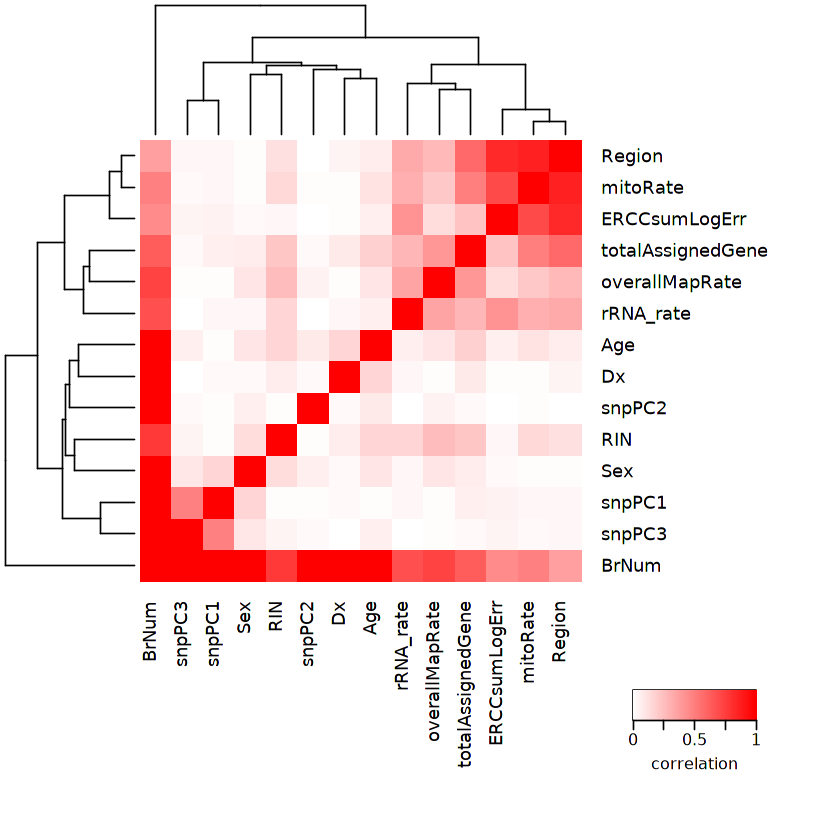

[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 118668 features left!"


Memory usage to store result: >9 Gb

Dividing work into 100 chunks...


Total:1189 s



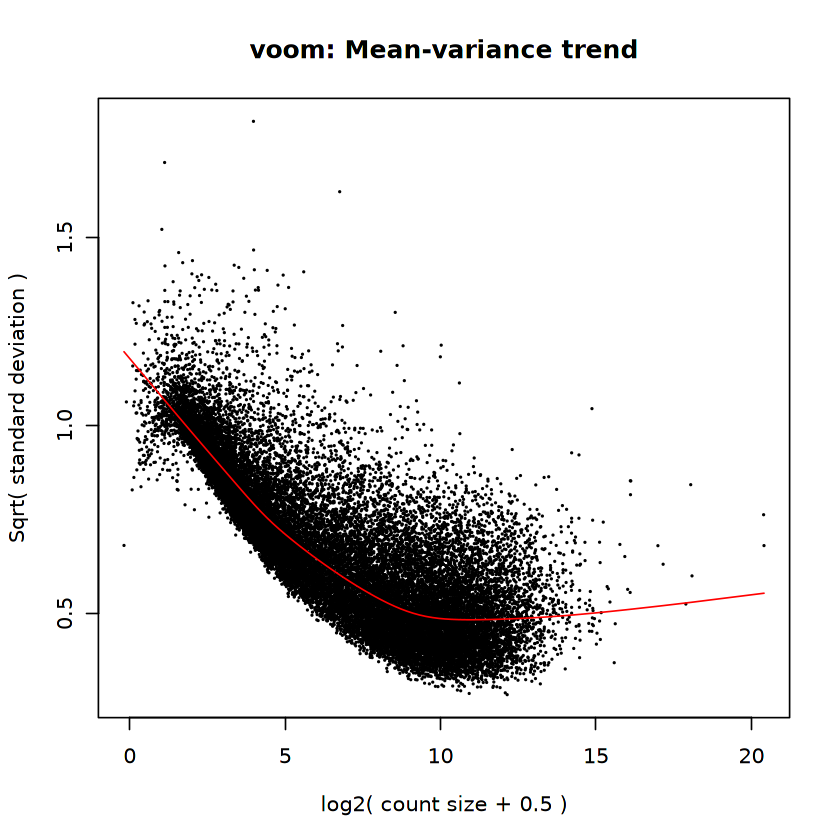

[1] "Fit model!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 118668 features left!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 118668 features left!"


Memory usage to store result: >9 Gb

Dividing work into 100 chunks...


Total:1192 s



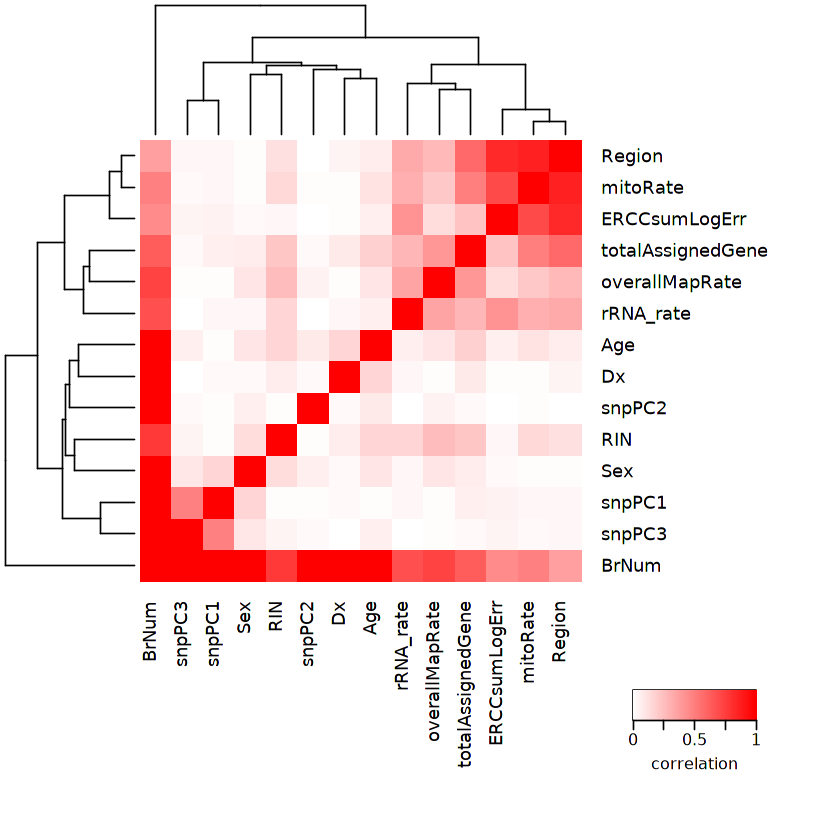

Dividing work into 100 chunks...


Total:2688 s



[1] "Comparison for: sex"
[1] "There are: 885 DE features!"
[1] "Comparison for: CvD_sex"
[1] "There are: 642 DE features!"
[1] "Comparison for: CvH_sex"
[1] "There are: 177 DE features!"
[1] "Comparison for: DvH_sex"
[1] "There are: 28 DE features!"
[1] "Generated residualized expression!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 118668 features left!"


Memory usage to store result: >9 Gb

Dividing work into 100 chunks...


Total:1184 s

Memory usage to store result: >9 Gb

Dividing work into 100 chunks...


Total:1163 s



[1] "Set parallel!"
[1] "Prepare data!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 173383 features left!"
[1] "Preform voom!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 173383 features left!"


Warning message in canCorPairs(form, x$samples):
“Regression model may be problematic.
High colinearity between variables:
  Dx and BrNum
  Age and BrNum
  snpPC1 and BrNum
  snpPC2 and BrNum
  snpPC3 and BrNum
  Sex and BrNum”


[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 173383 features left!"


Memory usage to store result: >13.2 Gb

Dividing work into 100 chunks...


Total:1709 s



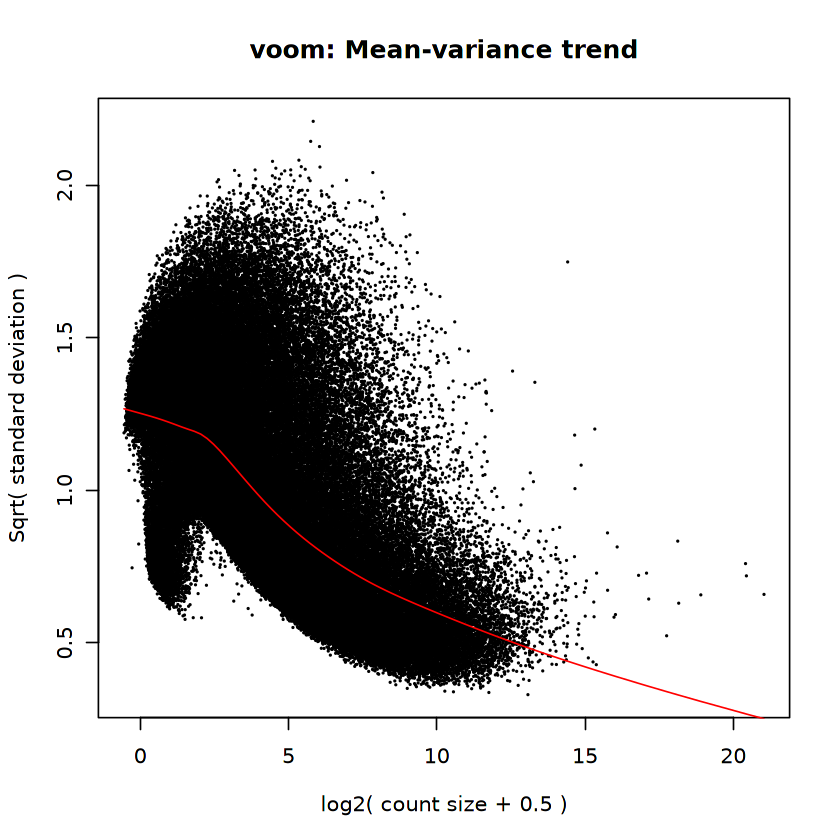

[1] "Fit model!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 173383 features left!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 173383 features left!"


Memory usage to store result: >13.2 Gb

Dividing work into 100 chunks...


Total:1724 s



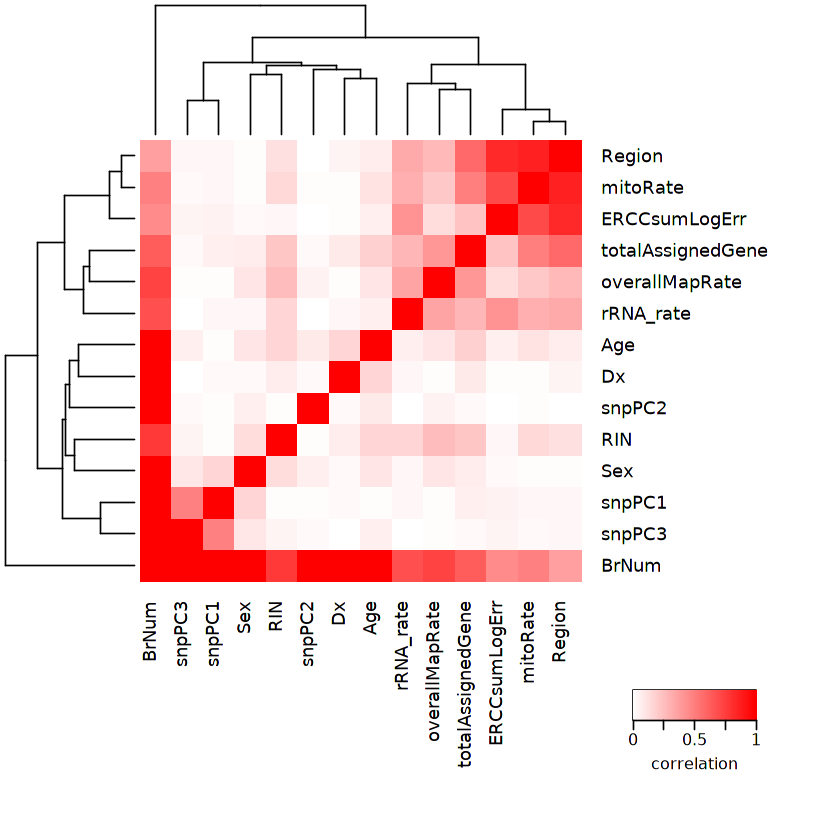

Dividing work into 100 chunks...


Total:3978 s



[1] "Comparison for: sex"
[1] "There are: 1358 DE features!"
[1] "Comparison for: CvD_sex"
[1] "There are: 324 DE features!"
[1] "Comparison for: CvH_sex"
[1] "There are: 47 DE features!"
[1] "Comparison for: DvH_sex"
[1] "There are: 58 DE features!"
[1] "Generated residualized expression!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 173383 features left!"


Memory usage to store result: >13.2 Gb

Dividing work into 100 chunks...


Total:1741 s

Memory usage to store result: >13.1 Gb

Dividing work into 100 chunks...


Total:1714 s



[1] "Set parallel!"
[1] "Prepare data!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 382284 features left!"
[1] "Preform voom!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 382284 features left!"


Warning message in canCorPairs(form, x$samples):
“Regression model may be problematic.
High colinearity between variables:
  Dx and BrNum
  Age and BrNum
  snpPC1 and BrNum
  snpPC2 and BrNum
  snpPC3 and BrNum
  Sex and BrNum”


[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 382284 features left!"


Memory usage to store result: >29.1 Gb

Dividing work into 100 chunks...


Total:3675 s



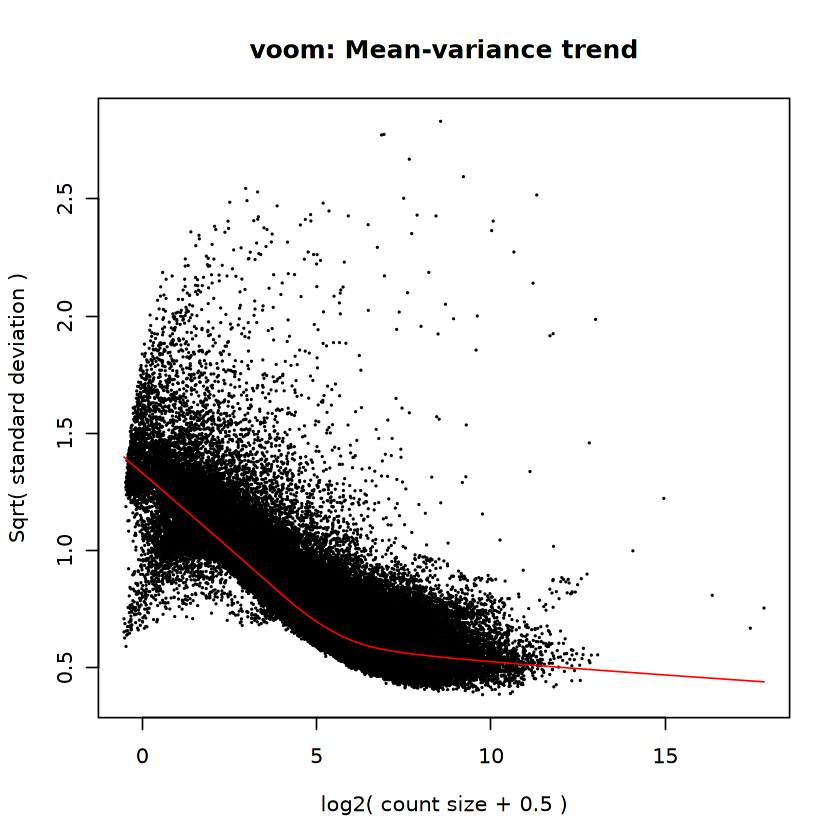

[1] "Fit model!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 382284 features left!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 382284 features left!"


Memory usage to store result: >29.1 Gb

Dividing work into 100 chunks...


Total:3613 s



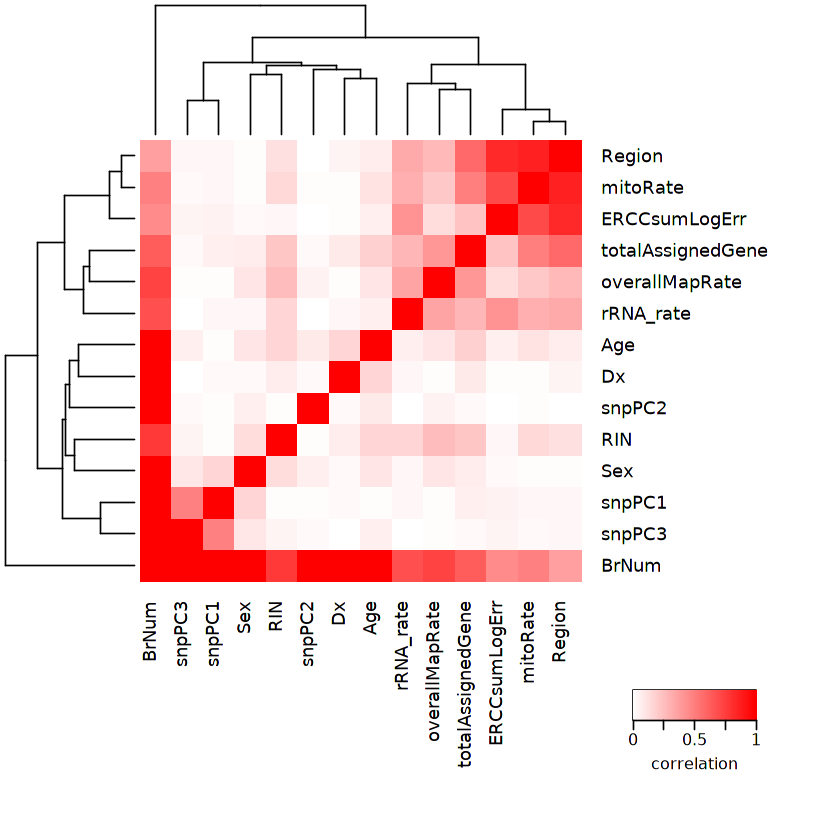

Dividing work into 100 chunks...


Total:%#4.0-1e s



[1] "Comparison for: sex"
[1] "There are: 4025 DE features!"
[1] "Comparison for: CvD_sex"
[1] "There are: 2254 DE features!"
[1] "Comparison for: CvH_sex"
[1] "There are: 129 DE features!"
[1] "Comparison for: DvH_sex"
[1] "There are: 131 DE features!"
[1] "Generated residualized expression!"
[1] "dlpfc"
[1] "caudate"
[1] "hippocampus"
[1] "There are: 382284 features left!"


Memory usage to store result: >29.1 Gb

Dividing work into 100 chunks...


Total:3642 s

Memory usage to store result: >29 Gb

Dividing work into 100 chunks...


Total:3604 s



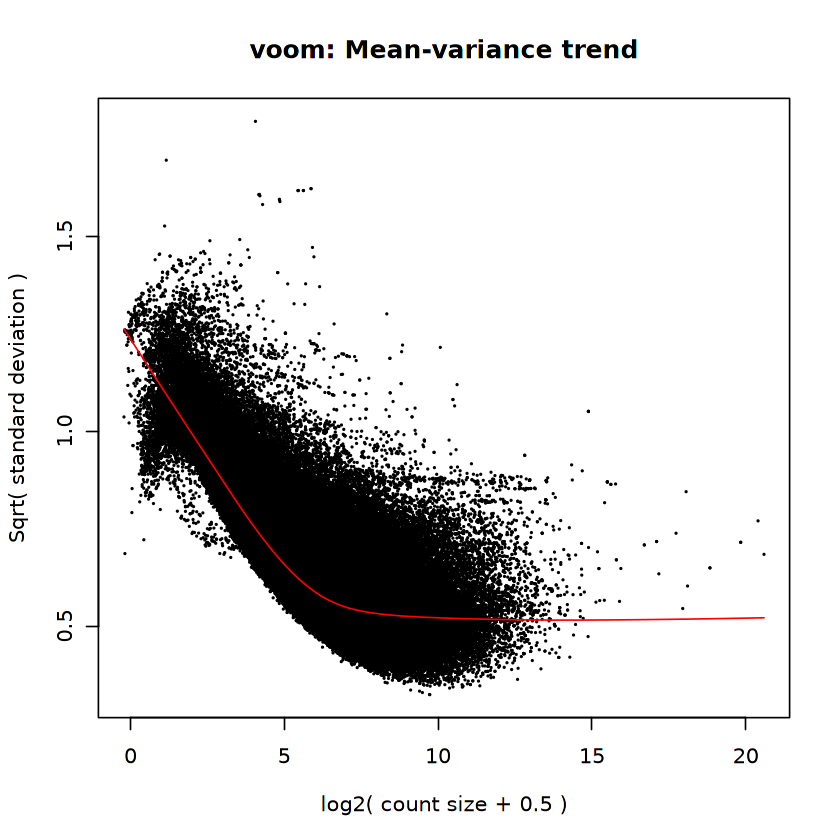

In [4]:
for(feature in c('genes', 'transcripts', 'junctions', 'exons')){
    flush.console()
    dir.create(feature)
    # Set parallel parameters
    print("Set parallel!")
    set_parallel(feature)
    # Prepare data
    print("Prepare data!")
    x <- memo_prepData(feature)
    save(x, file=paste0(feature, "/normData.RData"))
    # Preform voom
    print("Preform voom!")
    v <- memo_voom(feature)
    save(v, file=paste0(feature,'/voom_dream.RData'))
    # Fit model and apply eBayes
    print("Fit model!")
    fit = memo_dream(feature)
    # Save differential expression
    extract_de("SexM", "sex", fit, feature)
    extract_de("SexM:RegionDLPFC", "CvD_sex", fit, feature)
    extract_de("SexM:RegionHIPPO", "CvH_sex", fit, feature)
    extract_de("L2", "DvH_sex", fit, feature)
    # Calculate residuals
    print("Generated residualized expression!")
    memo_res(feature)
}

## Repreducibility Information

In [5]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-08-04 05:59:53 EDT"

    user   system  elapsed 
38648.65 11424.10 64363.82 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-08-04                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package              * version    date       lib source                                   
 annotate               1.68.0     2020-10-27 [1] Bioconductor                             
 AnnotationDbi          1.52.0     2020-10-27 [1] Bioconductor                             
 assertthat             0.2.1      2019-03-21 [1] CRAN (R 4.0.2)                           
 ba